# **Explainable AI Project on Parkinson's Data**

# This Notebook demonstrates the Usage of SHAP an Explainable AI Library on a Classifier Model built on Parkinson's Data.



Parkinson's Data was created by  Max Little of the University of Oxford, in collaboration with the National Centre for Voice and Speech, Denver, Colorado, who recorded the speech signals. The original study published the feature extraction methods for general voice disorders.

You can find this at https://archive.ics.uci.edu/ml/datasets/parkinsons


**Data Set Information:**

This dataset is composed of a range of biomedical voice measurements from 31 people, 23 with Parkinson's disease (PD). Each column in the table is a particular voice measure, and each row corresponds one of 195 voice recording from these individuals ("name" column). The main aim of the data is to discriminate healthy people from those with PD, according to "status" column which is set to 0 for healthy and 1 for PD.


**Attribute Information:**

Matrix column entries (attributes):
name - ASCII subject name and recording number
MDVP:Fo(Hz) - Average vocal fundamental frequency
MDVP:Fhi(Hz) - Maximum vocal fundamental frequency
MDVP:Flo(Hz)  - Minimum vocal fundamental frequency
MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP - Several measures of variation in fundamental frequency
MDVP:Shimmer,MDVP:Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,MDVP:APQ,Shimmer:DDA - Several measures of variation in amplitude
NHR,HNR - Two measures of ratio of noise to tonal components in the voice
status - Health status of the subject (one) - Parkinson's, (zero) - healthy
RPDE,D2 - Two nonlinear dynamical complexity measures
DFA - Signal fractal scaling exponent
spread1,spread2,PPE - Three nonlinear measures of fundamental frequency variation.

**1.Install & Import Necessary Libraraies**

In [1]:
pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 569 kB 7.4 MB/s 


In [6]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, plot_confusion_matrix, accuracy_score, f1_score, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV,StratifiedKFold

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [7]:
import shap

shap.initjs()

**2. Loading Dataset**

In [5]:
data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/X AI/parkinsons.data")
data.head()

,name,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,...,Shimmer:DDA,NHR,HNR,status,RPDE,DFA,spread1,spread2,D2,PPE
0,phon_R01_S01_1,119.992,157.302,74.997,0.00784,0.00007,0.00370,0.00554,0.01109,0.04374,...,0.06545,0.02211,21.033,1,0.414783,0.815285,-4.813031,0.266482,2.301442,0.284654
1,phon_R01_S01_2,122.400,148.650,113.819,0.00968,0.00008,0.00465,0.00696,0.01394,0.06134,...,0.09403,0.01929,19.085,1,0.458359,0.819521,-4.075192,0.335590,2.486855,0.368674
2,phon_R01_S01_3,116.682,131.111,111.555,0.01050,0.00009,0.00544,0.00781,0.01633,0.05233,...,0.08270,0.01309,20.651,1,0.429895,0.825288,-4.443179,0.311173,2.342259,0.332634
3,phon_R01_S01_4,116.676,137.871,111.366,0.00997,0.00009,0.00502,0.00698,0.01505,0.05492,...,0.08771,0.01353,20.644,1,0.434969,0.819235,-4.117501,0.334147,2.405554,0.368975
4,phon_R01_S01_5,116.014,141.781,110.655,0.01284,0.00011,0.00655,0.00908,0.01966,0.06425,...,0.10470,0.01767,19.649,1,0.417356,0.823484,-3.747787,0.234513,2.332180,0.410335


In [8]:

data.shape

(195, 24)

It consists of 24 Columns(features) & 195 Rows (instances)

**3. Data Preprocessing**

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195 entries, 0 to 194
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              195 non-null    object 
 1   MDVP:Fo(Hz)       195 non-null    float64
 2   MDVP:Fhi(Hz)      195 non-null    float64
 3   MDVP:Flo(Hz)      195 non-null    float64
 4   MDVP:Jitter(%)    195 non-null    float64
 5   MDVP:Jitter(Abs)  195 non-null    float64
 6   MDVP:RAP          195 non-null    float64
 7   MDVP:PPQ          195 non-null    float64
 8   Jitter:DDP        195 non-null    float64
 9   MDVP:Shimmer      195 non-null    float64
 10  MDVP:Shimmer(dB)  195 non-null    float64
 11  Shimmer:APQ3      195 non-null    float64
 12  Shimmer:APQ5      195 non-null    float64
 13  MDVP:APQ          195 non-null    float64
 14  Shimmer:DDA       195 non-null    float64
 15  NHR               195 non-null    float64
 16  HNR               195 non-null    float64
 1

There are NO NULL VALUES.

Except name and status, all columns were of  continuous data type.

In [11]:
features = data.drop(["name",'status'],axis =1)
print(features.shape)
features.head()

(195, 22)


,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,MDVP:Shimmer(dB),...,MDVP:APQ,Shimmer:DDA,NHR,HNR,RPDE,DFA,spread1,spread2,D2,PPE
0,119.992,157.302,74.997,0.00784,0.00007,0.00370,0.00554,0.01109,0.04374,0.426,...,0.02971,0.06545,0.02211,21.033,0.414783,0.815285,-4.813031,0.266482,2.301442,0.284654
1,122.400,148.650,113.819,0.00968,0.00008,0.00465,0.00696,0.01394,0.06134,0.626,...,0.04368,0.09403,0.01929,19.085,0.458359,0.819521,-4.075192,0.335590,2.486855,0.368674
2,116.682,131.111,111.555,0.01050,0.00009,0.00544,0.00781,0.01633,0.05233,0.482,...,0.03590,0.08270,0.01309,20.651,0.429895,0.825288,-4.443179,0.311173,2.342259,0.332634
3,116.676,137.871,111.366,0.00997,0.00009,0.00502,0.00698,0.01505,0.05492,0.517,...,0.03772,0.08771,0.01353,20.644,0.434969,0.819235,-4.117501,0.334147,2.405554,0.368975
4,116.014,141.781,110.655,0.01284,0.00011,0.00655,0.00908,0.01966,0.06425,0.584,...,0.04465,0.10470,0.01767,19.649,0.417356,0.823484,-3.747787,0.234513,2.332180,0.410335


In [15]:
y = data["status"]
y.head()

0    1
1    1
2    1
3    1
4    1
Name: status, dtype: int64


Standarization of Input Data

In [13]:
scaler = StandardScaler()
features_sc = pd.DataFrame(scaler.fit_transform(features))

In [14]:
features_sc.head()

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
0,-0.829300,-0.436165,-0.952037,0.334914,0.749759,0.132963,0.760800,0.131755,0.745985,0.739536,...,0.332985,0.607532,-0.067893,-0.193225,-0.807838,1.760814,0.801323,0.480477,-0.210531,0.868886
1,-0.770972,-0.530974,-0.057721,0.715418,1.037674,0.453892,1.276809,0.452684,1.681731,1.768464,...,1.159454,1.548254,-0.137843,-0.634508,-0.387524,1.837562,1.479853,1.311185,0.275077,1.803605
2,-0.909476,-0.723168,-0.109875,0.884991,1.325589,0.720770,1.585687,0.721813,1.202693,1.027636,...,0.699187,1.175323,-0.291633,-0.279760,-0.662075,1.942048,1.141445,1.017682,-0.103629,1.402661
3,-0.909622,-0.649092,-0.114229,0.775389,1.325589,0.578885,1.284076,0.577677,1.340396,1.207698,...,0.806859,1.340229,-0.280719,-0.281346,-0.613134,1.832380,1.440945,1.293840,0.062145,1.806954
4,-0.925657,-0.606245,-0.130608,1.368893,1.901418,1.095750,2.047187,1.096793,1.836448,1.552389,...,1.216839,1.899461,-0.178026,-0.506745,-0.783021,1.909364,1.780940,0.096195,-0.130026,2.267082


**4.MODEL Fitting**

In [16]:
x_train,x_test,y_train,y_test   =  train_test_split(features_sc,y,test_size= 0.25,random_state= 10)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(146, 22)
(49, 22)
(146,)
(49,)


In [17]:
classifier = XGBClassifier()
params = {"n_estimators":[100,200,300,400,500],"max_depth":[3,4,5,6,7,8],'min_child_weight':range(1,6,2)}
cv= StratifiedKFold(n_splits = 10,shuffle = True, random_state = 10)
grid = GridSearchCV(classifier,param_grid= params,cv = cv,scoring= "precision")
grid.fit(x_train,y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=10, shuffle=True),
             estimator=XGBClassifier(),
             param_grid={'max_depth': [3, 4, 5, 6, 7, 8],
                         'min_child_weight': range(1, 6, 2),
                         'n_estimators': [100, 200, 300, 400, 500]},
             scoring='precision')

In [18]:
grid.best_params_

{'max_depth': 4, 'min_child_weight': 3, 'n_estimators': 100}

In [20]:
classifier_1 = XGBClassifier(n_estimators=100, max_depth=4,min_child_weight=3)
classifier_1.fit(x_train,y_train)
y_pred = classifier_1.predict(x_test)

In [37]:
pd.Series(y_pred).value_counts()

1    37
0    12
dtype: int64

**5. Performance Evaluation**

Accuracy of Model is 93.88 %
Confusion Matrix is


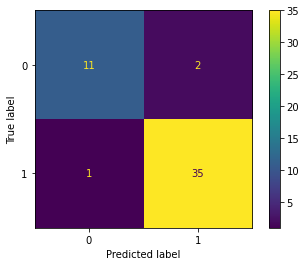

In [30]:
print("Accuracy of Model is %.2f"%(accuracy_score(y_test,y_pred)*100),"%")
print("Confusion Matrix is")
plt.show(plot_confusion_matrix(classifier_1,x_test,y_test))

In [31]:
print("Classification Report :\n",classification_report(y_test,y_pred))

Classification Report :
               precision    recall  f1-score   support

           0       0.92      0.85      0.88        13
           1       0.95      0.97      0.96        36

    accuracy                           0.94        49
   macro avg       0.93      0.91      0.92        49
weighted avg       0.94      0.94      0.94        49



**6.EXPLAINABLE AI**

In [32]:
explainer = shap.TreeExplainer(classifier_1)
shap_values = explainer.shap_values(x_test)

In [33]:
pd.DataFrame(shap_values).head()

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
0,-0.437880,-0.811528,0.002694,0.0,-0.074301,0.349205,0.0,0.0,0.014179,0.164872,...,0.026222,0.0,0.231550,-0.006732,0.145377,0.144578,0.989622,0.263564,-1.083881,0.411960
1,-0.101981,0.297911,0.003903,0.0,-0.078419,0.427612,0.0,0.0,0.014179,0.164872,...,0.026222,0.0,0.227660,-0.006732,-0.241833,0.108989,0.900673,0.253005,-0.766137,0.338573
2,0.325885,0.935190,0.007214,0.0,-0.074301,0.359358,0.0,0.0,0.014179,0.164872,...,0.026222,0.0,0.153851,-0.006732,0.005288,0.239562,0.631730,0.495300,0.657493,0.420198
3,0.359776,-0.793213,0.007214,0.0,-0.078419,0.280950,0.0,0.0,-0.045268,-0.187500,...,-0.020228,0.0,0.119926,-0.070584,-0.208101,-0.161835,0.657659,0.504454,0.695075,0.319889
4,-0.337160,0.572505,0.008023,0.0,-0.179814,-0.391313,0.0,0.0,0.004653,0.132784,...,0.010221,0.0,-0.534254,-0.113143,0.075210,-0.020745,-0.659075,0.229404,-1.005053,-0.538424


The Above is the Matrix of SHAP values.
Each row sums to the difference in the Model Output(y_pred) and the Original value(y_test).

This Difference explains us why the Model predicted that specific value .



In [34]:
explainer.expected_value

1.4914978

The Expected Value is 1.4914978.The values abouve this base values are predicted 1(PD)and below this are predicted 0 (Healthy)

**GRAPHICAL REPRESENTATION**

Local Predictions

**FORCE PLOTS**

All Shap Values has some significance for each instance Prediction which can be graphically explored by Force Plots.

In [36]:
print("Prediction for 1st Instance :",y_pred[0])
print("Explanation:")

shap.initjs()
shap.force_plot(explainer.expected_value,shap_values[0,:],features.columns)

Prediction for 1st Instance : 1
Explanation:


Significance of various features in Predicting first instance of test set as 1.

We can observe that features *spread1* and *PPE* has significant Positive shap values where as *D2,MDVP:Fhi &* MDVP:Fo has Significant Negative Shap Values.

In [38]:
shap.initjs()
shap.force_plot(explainer.expected_value,shap_values[1,:],features.columns)

lets check for the instance where the Prediction is 0

In [40]:
y_pred

array([1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0,
       0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1])

In [43]:
print("Prediction for 5th Instance :",y_pred[4])
print("Explanation:")
shap.initjs()
shap.force_plot(explainer.expected_value,shap_values[4,:],features.columns)

Prediction for 5th Instance : 0
Explanation:


Sum of  Shap Values :-1.63 is less than Expected Value 1.491

MULTIPLE PREDICTIONS

In [44]:
shap.initjs()
shap.force_plot(explainer.expected_value,shap_values,features.columns)

The Above Visualization can be interacted in Varios ways by Using Drop Down lists.

We can observe that first 8 test samples are Healthy and and from 9-28 are having PD.

Various Visualizations for each feature variation w.r.t Shap values can be plotted individually with the help of Drop Down lists provided.

**SUMMARY PLOTS**

Global Predictions - Feature Importance

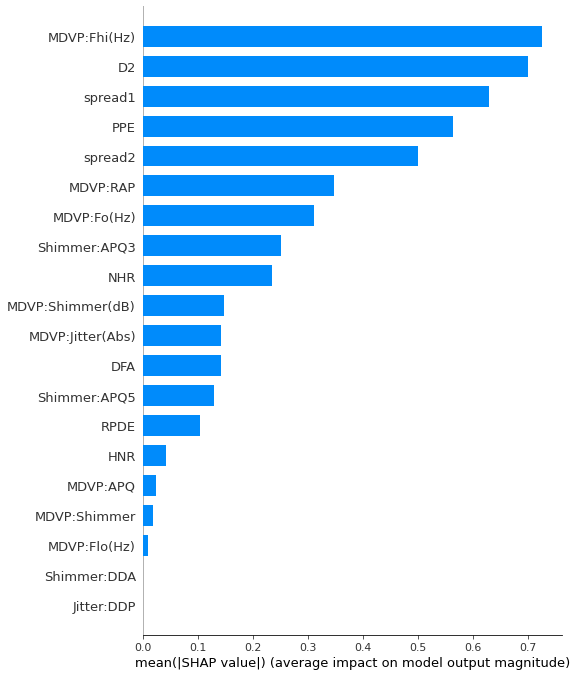

In [46]:
shap.initjs()
shap.summary_plot(shap_values, 
                  features.columns, plot_type="bar")

Above Summary plot shows features & their Significance decreasingly.

We can observe that the features *MDVP:Fhi(Hz), D2, spread1, PPE, spread2, MDVP RAP, MDVP:Fo(Hz)* are Very Important while Shimmer:DDA & jitter:DDP are Least Important.

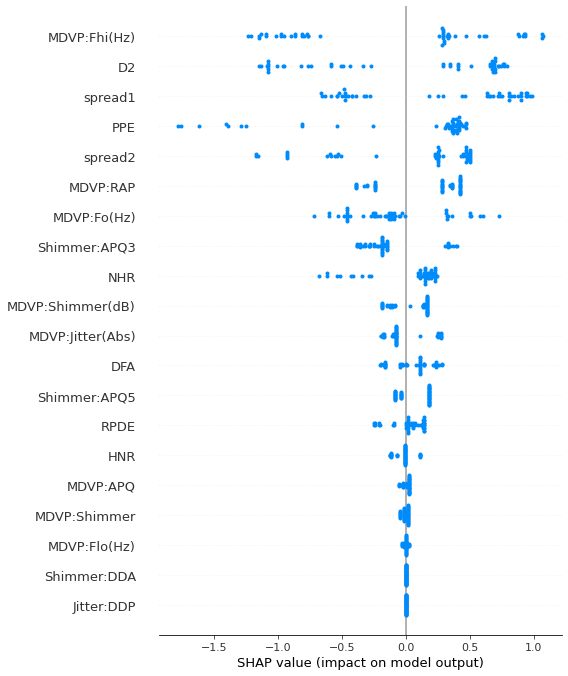

In [48]:
shap.initjs()
shap.summary_plot(shap_values, features.columns)

The Above is the Density Scatter plot of Shap values.

**DEPENDENCE PLOTS**

Plots the value of the feature on the x-axis and the SHAP value of the same feature on the y-axis.

Vertical dispersion of the data points represents interaction effects.

As Observed in the previous plots that values in Pink color are indiations for PD, where as in blue are indications for Healthy.

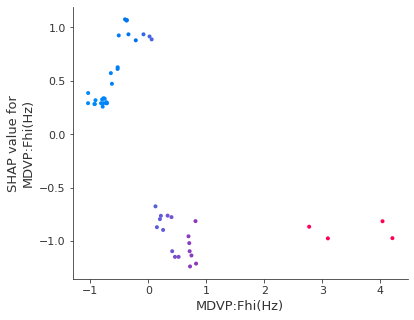

In [66]:
shap.initjs()
shap.dependence_plot(ind='MDVP:Fhi(Hz)',interaction_index='MDVP:Fhi(Hz)',
                     shap_values = shap_values,
                     features = x_test,
                     feature_names = features.columns,
                     display_features = x_test)

Values less than 0 are higher indications for Healthy Person, whereas above 2 are higher indications for person with PD

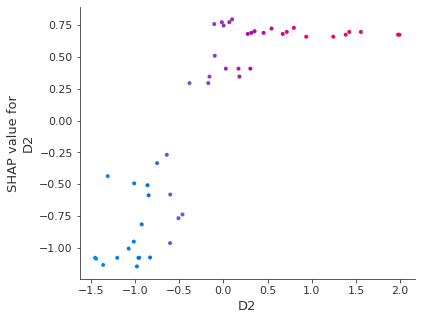

In [65]:
shap.initjs()
shap.dependence_plot(ind='D2',interaction_index='D2',
                     shap_values = shap_values,
                     features = x_test,
                     feature_names = features.columns,
                     display_features = x_test)

Standarised D2 values greater than 0 are in pink (mostly) which indicates higher chances for PD.

values less than 0 which are mostly blue, indicates lower chances of PD.

Two way PAIR DEPENDENCE PLOTS

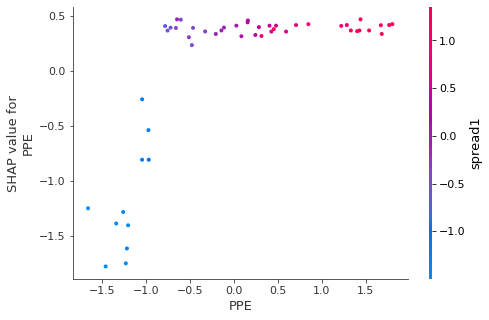

In [69]:
shap.initjs()
shap.dependence_plot(ind='PPE',interaction_index='spread1',
                     shap_values = shap_values,
                     features = x_test,
                     feature_names = features.columns,
                     display_features = x_test)

Plotting of Shap Values of a feature against its feature values with another feature for colouring Purpose gives more Interactive insights. 

Values of PPE above 0.5 also have high spread1 values, which both are aligned in same direction, indicating high chances for PD

So we have seen practical example of Explainable AI using SHAP library on Parkinson's Data and Visualized significance of various features on the Predictions, Globally and Locally along with their inter dependency.